In [1]:
# Below loads all the preliminaries for the analysis.
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import simplefilter


# statistical modelling
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [2]:
"""
#ML modelling
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
#from sktime.transformations.series.detrend import Deseasonalizer, Detrender
#from sktime.utils.plotting import plot_series
"""

'\n#ML modelling\nfrom sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error\nfrom sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error\n\nfrom sktime.forecasting.naive import NaiveForecaster\nfrom sktime.forecasting.theta import ThetaForecaster\nfrom sktime.forecasting.trend import PolynomialTrendForecaster\nfrom sktime.performance_metrics.forecasting import (\n    MeanAbsolutePercentageError,\n    mean_absolute_percentage_error,\n)\n#from sktime.transformations.series.detrend import Deseasonalizer, Detrender\n#from sktime.utils.plotting import plot_series\n'

In [3]:
"""



from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')
"""
#pd.set_option('display.max_rows', None)

"\n\n\n\nfrom tqdm import tqdm_notebook\n\nfrom itertools import product\n\ndef mean_absolute_percentage_error(y_true, y_pred):\n    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100\n\nimport warnings\nwarnings.filterwarnings('ignore')\n"

In [4]:
data = pd.read_csv(r'D:\Documents\gamestop.csv', index_col=0, parse_dates=['date'])
data.sort_values(by='date', ascending='True')


,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-19,9.900000,9.900000,9.375000,9.550000,1852600.0,6.430017
2002-02-20,9.600000,9.875000,9.525000,9.875000,1723200.0,6.648838
...,...,...,...,...,...,...
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996


In [5]:
ts = data
ts = ts.sort_index()
#ts.index = ts.index.to_period(freq='M')
ts = ts[725:4000]
#ts = ts.fillna(method='ffill')

In [6]:
ts = ts.asfreq('M')
#ts = ts.fillna(method='ffill')
ts['close_price'].interpolate(method='linear', inplace=True)

In [7]:
ts = ts['close_price']

In [8]:
ts.describe()

count    157.000000
mean      29.067818
std       11.119048
min        9.545000
25%       21.690001
50%       25.300000
75%       37.310001
max       62.110001
Name: close_price, dtype: float64

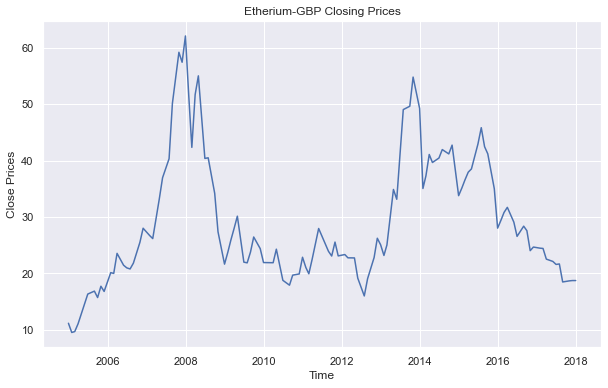

In [9]:
#line graph of closing price, shows seasonality/trend 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Close Prices')
plt.plot(ts)
plt.title('Etherium-GBP Closing Prices')
plt.show()


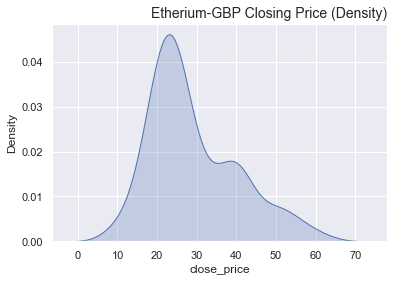

In [10]:
#Density shows positive skewness 
sns.set_style('darkgrid')
sns.kdeplot(ts, shade=True)
plt.title('Etherium-GBP Closing Price (Density)', loc = 'right', fontsize=14)

plt.show()

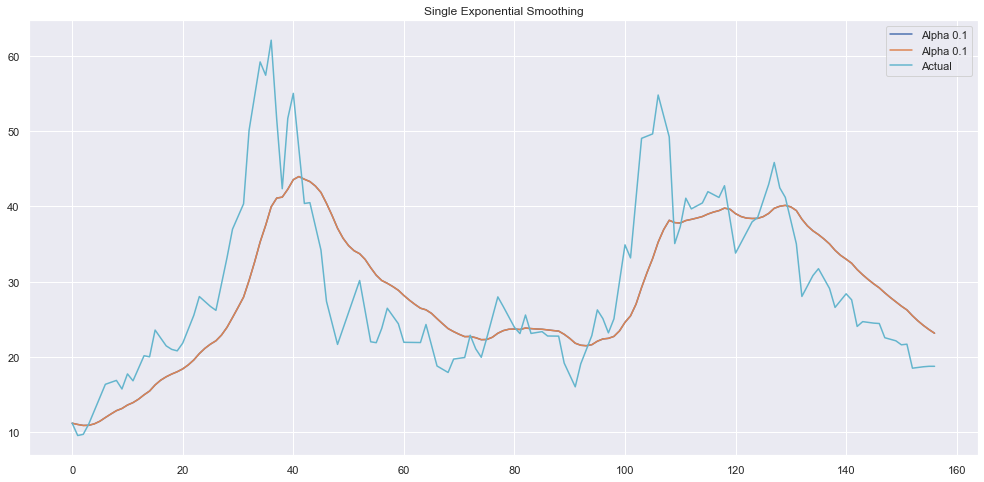

In [11]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title('Single Exponential Smoothing')
    plt.grid(True);

plot_exponential_smoothing(ts, [0.1, 0.1])

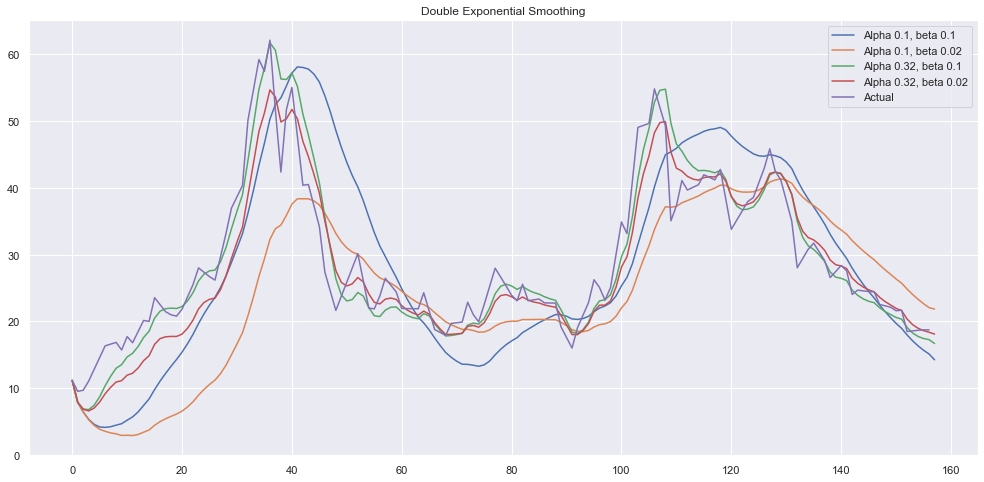

In [12]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(ts, alphas=[0.1, 0.32], betas=[0.1, 0.02])

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


<AxesSubplot:title={'center':'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='date'>

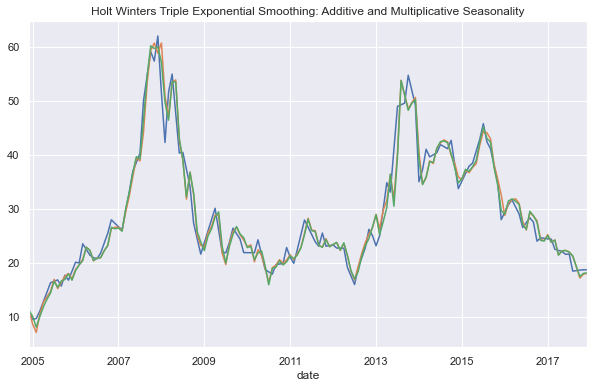

In [13]:
ts_add = ExponentialSmoothing(ts, trend='add',seasonal='add',seasonal_periods=65).fit().fittedvalues

ts_mul = ExponentialSmoothing(ts, trend='mul',seasonal='mul',seasonal_periods=65).fit().fittedvalues

plt.figure(figsize=(10,6))

ts.plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')
ts_add.plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')
ts_mul.plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

In [14]:
from typing import *

def initial_trend(series: List, uppercase_m: int) -> float:
    return sum([
        float(series[i+uppercase_m] - series[i]) / uppercase_m
        for i in range(uppercase_m)
    ]) / uppercase_m


def initial_seasonality(series: List, uppercase_m: int) -> List:
    initial_season = []
    n_seasons = int(len(series)/uppercase_m)

    season_averages = [sum(
        series[uppercase_m * i:uppercase_m * i + uppercase_m]
    ) / uppercase_m for i in range(n_seasons)]

    initial_season.extend([
        sum([series[uppercase_m*j+i]-season_averages[j]
             for j in range(n_seasons)]) / n_seasons
        for i in range(uppercase_m)
    ])

    return initial_season
def winters_es(series: List,
               uppercase_m: int,
               alpha: float=0.2,
               beta: float=0.2,
               gamma: float=0.15,
               future_steps: int=1) -> List:
    
    i_l = [series[0]]
    i_t = [initial_trend(series, uppercase_m)]
    i_s = initial_seasonality(series, uppercase_m)

    forecasts = []
    for t in range(len(series) + future_steps):

        if t >= len(series):
            m = t - len(series) + 1
            forecasts.append(
                (i_l[-1] + m * i_t[-1]) + i_s[t % uppercase_m]
            )

        else:
            l_t = alpha * (series[t] - i_s[t % uppercase_m]) + (1 - alpha) * (i_l[-1] + i_t[-1])

            i_t[-1] = beta * (l_t - i_l[-1]) + (1 - beta) * i_t[-1]
            i_l[-1] = l_t

            i_s[t % uppercase_m] = gamma * (series[t] - l_t) + (1 - gamma) * i_s[t % uppercase_m]

            forecasts.append(
                (i_l[-1] + i_t[-1]) + i_s[t % uppercase_m]
            )

    return forecasts

In [15]:
#ts = ts.asfreq('D', method='pad')
forecast = winters_es(ts, 12)

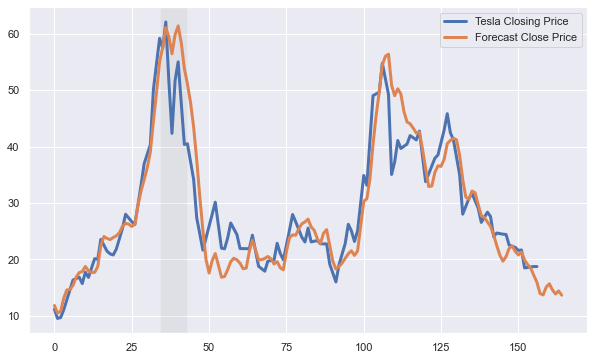

In [16]:
plt.figure(
figsize=(10, 6)
    )


data = ts.values.tolist()

k = 10

last_months = list(range(34, 34 + k))

forecast = winters_es(data, 12, future_steps=8)
plt.plot(data, linewidth=3, label='Tesla Closing Price')
plt.plot(forecast, linewidth=3, label='Forecast Close Price')
plt.axvspan(*(last_months[0], last_months[-1]), 
facecolor='grey', 
alpha=0.1)
plt.legend()
plt.show()

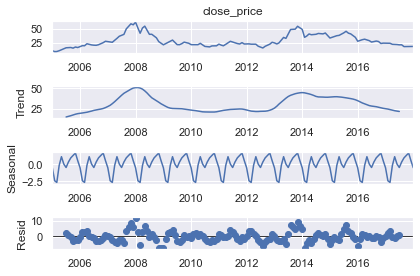

In [17]:
decomp = seasonal_decompose(ts)

decomp.plot()
plt.show()

---------------------------------------------------

AR MODEL

predicted=38.615259, expected=35.186666
predicted=39.595815, expected=36.573332
predicted=40.299985, expected=37.959999
predicted=45.445469, expected=38.540001
predicted=43.672101, expected=40.750000
predicted=43.334854, expected=42.959999
predicted=47.233183, expected=45.849998
predicted=45.353588, expected=42.480000
predicted=46.977008, expected=41.209999
predicted=44.902996, expected=38.119999
predicted=39.533922, expected=35.029999
predicted=37.740570, expected=28.040001
predicted=29.685260, expected=29.430000
predicted=35.728940, expected=30.820000
predicted=34.788398, expected=31.730000
predicted=34.129876, expected=30.415000
predicted=34.841078, expected=29.100000
predicted=31.680618, expected=26.580000
predicted=28.160060, expected=27.485000
predicted=31.228422, expected=28.389999
predicted=31.254022, expected=27.590000
predicted=30.907006, expected=24.049999
predicted=28.174339, expected=24.690001
predicted=30.412703, expected=24.590000
predicted=29.854464, expected=24.490000


C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


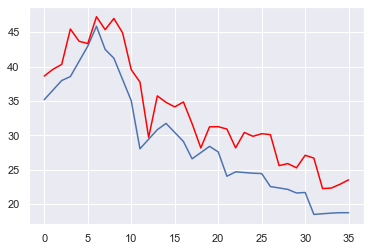

In [18]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 20
model = AutoReg(ar_train, lags=25)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(ar_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()

MA Model

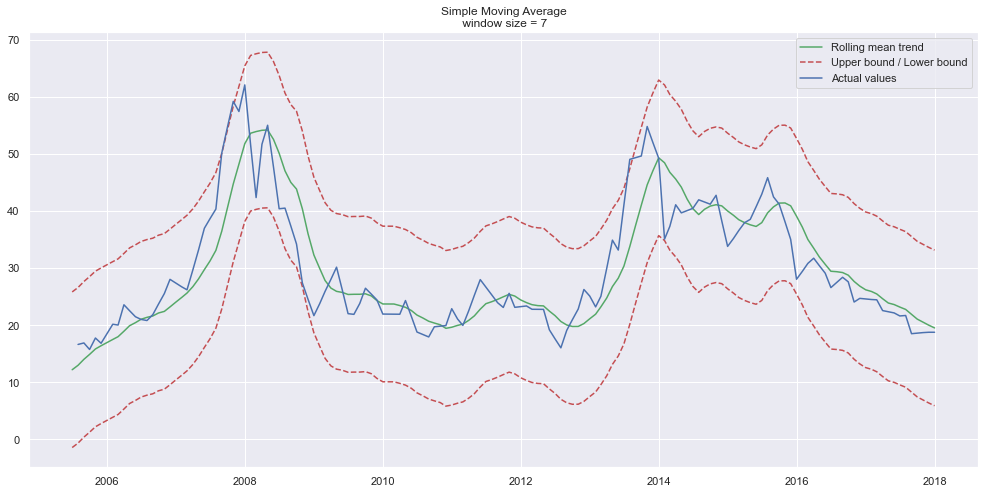

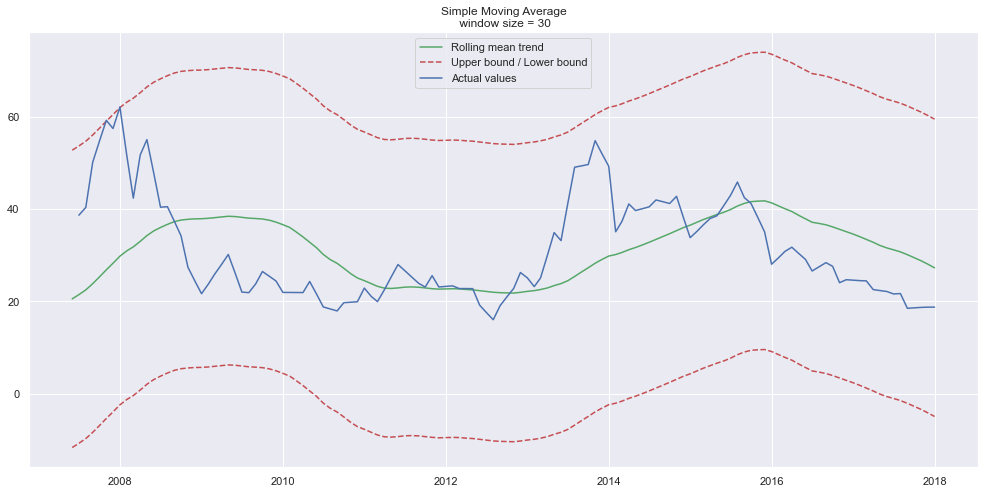

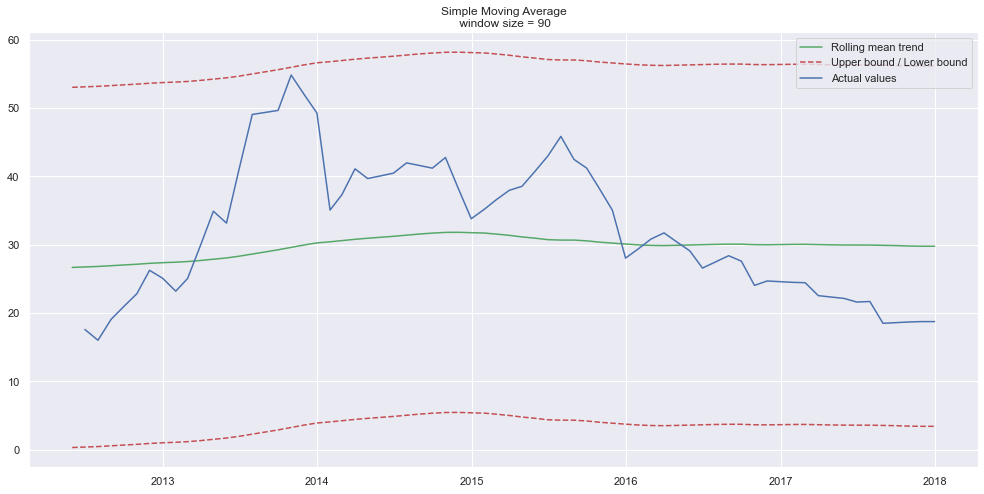

In [19]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 7, plot_intervals=True)

#Smooth by the previous month (30 days)
plot_moving_average(ts, 30, plot_intervals=True)

#Smooth by previous quarter (90 days)
plot_moving_average(ts, 90, plot_intervals=True)

In [20]:
# Take the first difference to remove to make the process stationary
# data_diff = ts - ts.shift(1)

# Use pandas to make difference 
data_diff = ts.diff()

# Remove nans
data_diff = data_diff.dropna()

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


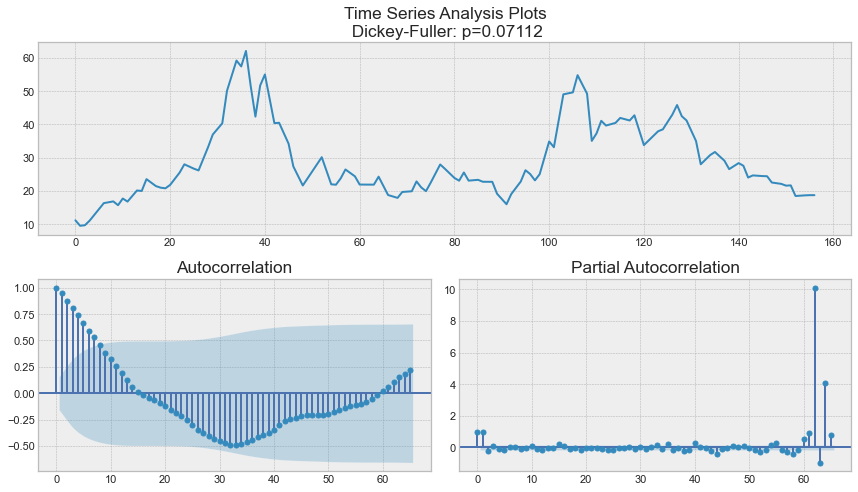

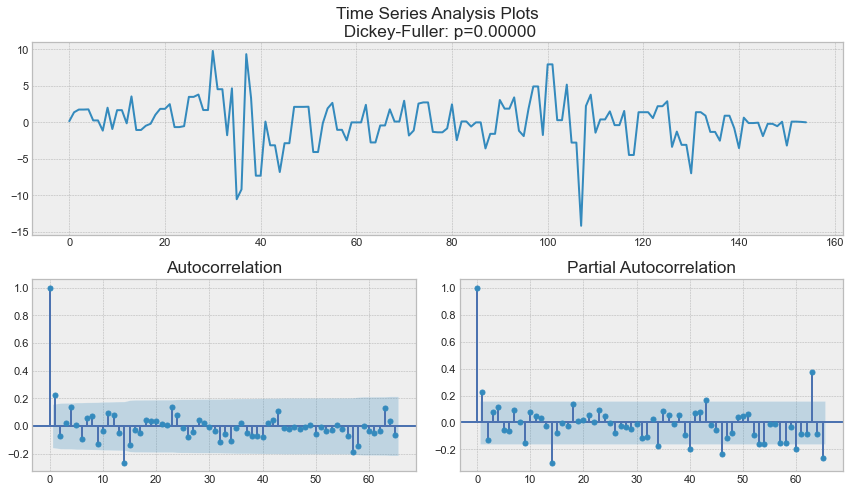

In [21]:
#Dickey-Fuller TEST


def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#plots normal time series for Dickey-Fuller Test
tsplot(ts.values, lags=65)

tsplot(data_diff.values[1:], lags=65)

In [22]:
adf_result=adfuller(ts.values)
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result))

{'adf': -2.7171339471820755,
 'pvalue': 0.07111998683543207,
 'usedlag': 4,
 'nobs': 152,
 'criticalvalues': {'1%': -3.474120870218417,
  '5%': -2.880749791423677,
  '10%': -2.5770126333102494},
 'icbest': 735.4571615613991}

In [23]:
import pmdarima as pm
from pmdarima.arima import auto_arima

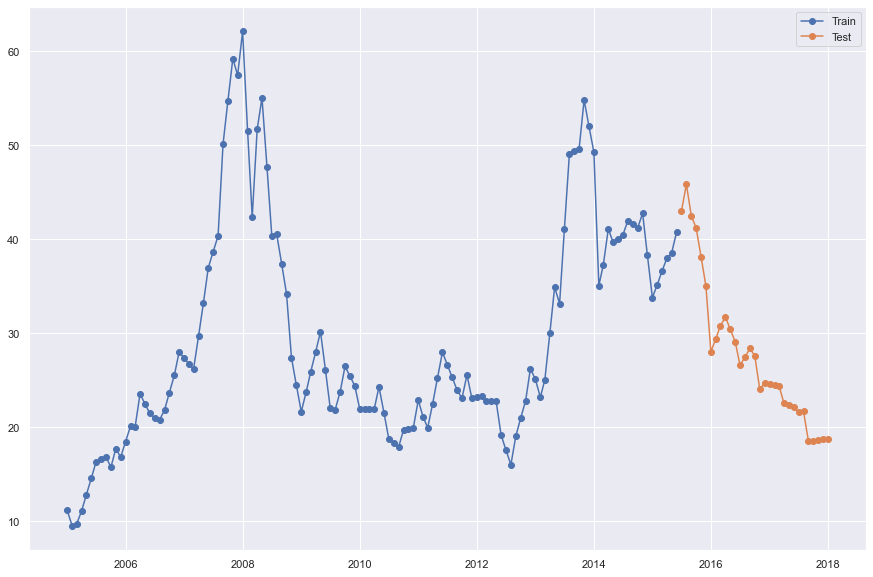

In [24]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

# Split
arima_train = ts.iloc[:split_idx]
arima_test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(15,10))
kws = dict(marker='o')
plt.plot(arima_train, label='Train', **kws)
plt.plot(arima_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [25]:
arima_model = auto_arima(arima_train, start_p=0, start_q=0,
                             max_p=5, max_q=5, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=680.231, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=642.504, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=676.366, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=628.208, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=632.517, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=629.445, Time=0.41 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=628.841, Time=0.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=627.099, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=641.644, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -309.549
Date:                             Sun, 13 Jun 2021   AIC                            627.099
Time:                                     19:12:08   BIC                            638.008
Sample:                                          0   HQIC                           631.526
                                             - 126                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2769      0.081      3.434      0.001       0.119       0.435
ar.S.L12      -0.7496      0.083     -8.998      0.000      -0.913      -0.586
ar.S.L24      -0.4044      0.118     -3.423      0.001      -0.636      -0.173
sigma2        13.0219      1.336      9.750      0.000      10.404      15.640
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                15.15
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.31
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


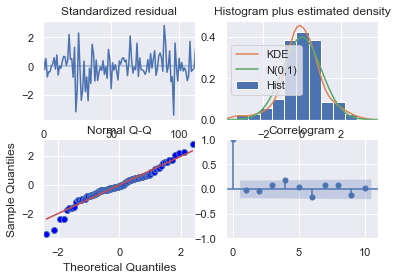

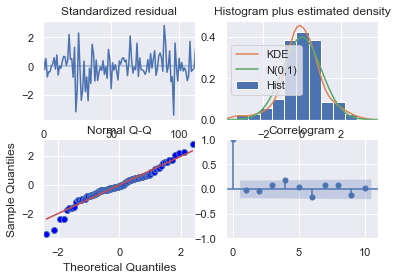

In [26]:
arima_model.plot_diagnostics()

In [27]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 31), index=arima_test.index)

prediction.columns = ['predicted_close_price']

print(prediction)

            predicted_close_price
date                             
2015-06-30              44.144958
2015-07-31              46.625659
2015-08-31              47.868581
2015-09-30              48.632270
2015-10-31              51.565697
2015-11-30              50.867355
2015-12-31              48.316791
2016-01-31              43.001838
2016-02-29              44.874467
2016-03-31              48.519609
2016-04-30              50.164447
2016-05-31              50.150535
2016-06-30              54.352149
2016-07-31              58.706217
2016-08-31              59.003887
2016-09-30              59.181546
2016-10-31              62.545420
2016-11-30              59.699936
2016-12-31              56.390615
2017-01-31              49.799607
2017-02-28              51.653071
2017-03-31              54.577252
2017-04-30              54.615082
2017-05-31              55.534152
2017-06-30              57.917885
2017-07-31              60.471107
2017-08-31              60.818961
2017-09-30    

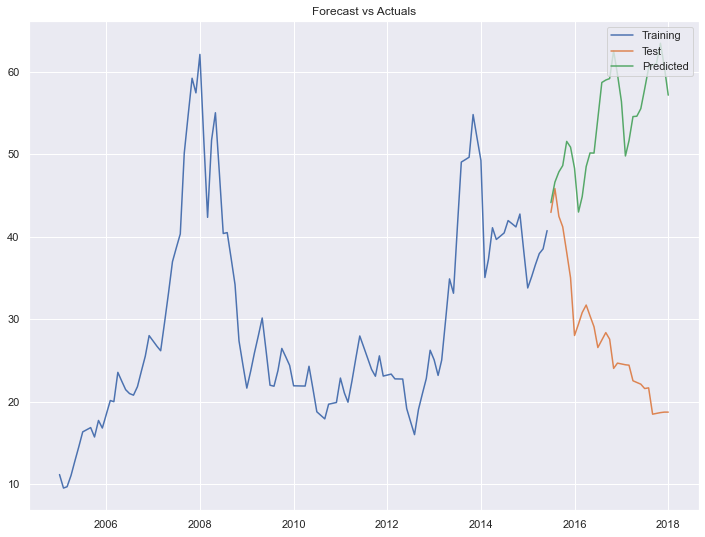

In [36]:
#forecasting with ARIMA

plt.figure(figsize=(12, 9))
plt.title("Forecast vs Actuals")
plt.plot(arima_train, label = "Training")
plt.plot(arima_test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = "upper right")
plt.show()

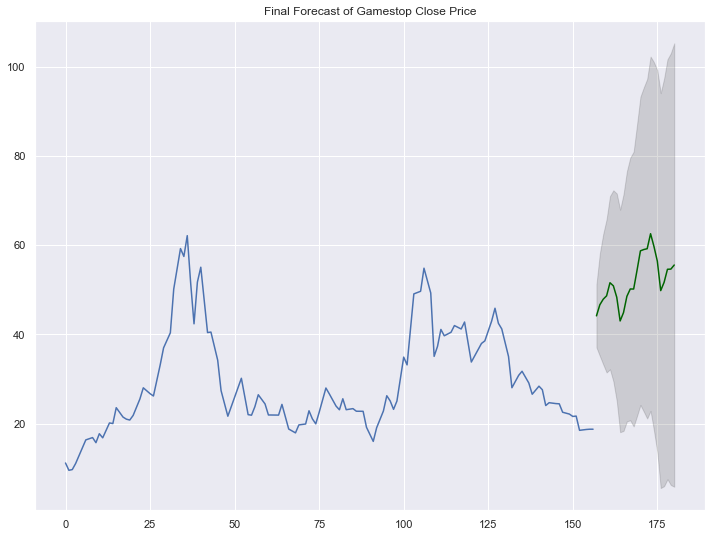

In [35]:
# Forecast
n_periods = 24
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts.values), len(ts.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 9))
plt.plot(ts.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Gamestop Close Price")
plt.show()

MACHINE LEARNING BELOW